# 4.1 — Elemental Encoder Comparison

This notebook trains CrabNet with **8 different elemental embeddings**
(without Pettifor `extend_features`) to evaluate encoder sensitivity.

It includes the 7 built-in CrabNet encoders **plus** the Pettifor
similarity matrix registered as a custom `elem_prop`.

> **Important**: CrabNet v2.0.8 has a bug where `elem_prop` is not
> propagated to the `Embedder`, silently defaulting all models to
> `mat2vec`. A monkey-patch is applied below to fix this.

Encoders tested:
`jarvis`, `magpie`, `mat2vec`, `oliynyk`, `onehot`, `ptable`, `random_200`, `pettifor`

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings('ignore')

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Patch SWA for PyTorch >= 2.x compatibility ---
from crabnet.utils.optim import SWA  # type: ignore
_original_swa_init = SWA.__init__
def _patched_swa_init(self, *args, **kwargs):
    _original_swa_init(self, *args, **kwargs)
    if not hasattr(self, '_optimizer_step_pre_hooks'):
        self._optimizer_step_pre_hooks = {}
    if not hasattr(self, '_optimizer_step_post_hooks'):
        self._optimizer_step_post_hooks = {}
SWA.__init__ = _patched_swa_init
# ------------------------------------------------

# --- Patch CrabNet elem_prop propagation bug ---
import tf_chpvk_pv.modeling.CrabNet.patches as _patches
importlib.reload(_patches)                    # pick up code changes without kernel restart
_patches.patch_crabnet_elem_prop()
# ------------------------------------------------

from crabnet.crabnet_ import CrabNet          # type: ignore
from crabnet.utils.data import groupby_formula # type: ignore

from tf_chpvk_pv.config import TRAINED_MODELS, FIGURES_DIR
from tf_chpvk_pv.modeling.CrabNet.utils import (
    DEVICE,
    get_raw_data,
    get_pettifor_features,
    register_pettifor_elem_prop,
    test_r2_score,
)

print(f'Device: {DEVICE}')

2026-02-17 12:05:40.653 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV


[patch] CrabNet elem_prop propagation fixed.
2026-02-17 12:05:41.151 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:<module>:19 - CrabNet device: mps
Device: mps


## Data Preparation

Load, clean, group, and split exactly as in notebook 4. Pettifor columns
are computed (to get the same train/val/test split) but then **dropped**
before training.

In [2]:
df = get_raw_data()
df.rename(columns={'bandgap': 'target', 'reduced_formulas': 'formula'}, inplace=True)

df_grouped = groupby_formula(df, how='median')

for formula in df_grouped['formula']:
    df_grouped.loc[df_grouped['formula'] == formula, 'source'] = (
        df.loc[df['formula'] == formula, 'source'].values[0]
    )
df_grouped_no_src = df_grouped.drop(columns=['source'])

train_df, val_df, test_df, feature_names = get_pettifor_features(
    df_grouped_no_src, original_df=df, train=True
)

# Register Pettifor as a CrabNet elem_prop (so it can be used like mat2vec, etc.)
register_pettifor_elem_prop()

# Drop Pettifor columns — encoder comparison uses only the elemental embedding
train_base = train_df.drop(columns=feature_names)
val_base   = val_df.drop(columns=feature_names)
test_base  = test_df.drop(columns=feature_names)

print(f'Train: {len(train_base)}  |  Val: {len(val_base)}  |  Test: {len(test_base)}')

The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
2026-02-17 12:05:51.213 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:register_pettifor_elem_prop:324 - Pettifor elem_prop already registered at /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV/.venv/lib/python3.10/site-packages/crabnet/data/element_properties/pettifor.csv
Train: 2902  |  Val: 363  |  Test: 363


## Train & Evaluate Each Encoder


Encoder: magpie

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11896070 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 308656.53formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 355814.99formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.45 val mae: 0.449


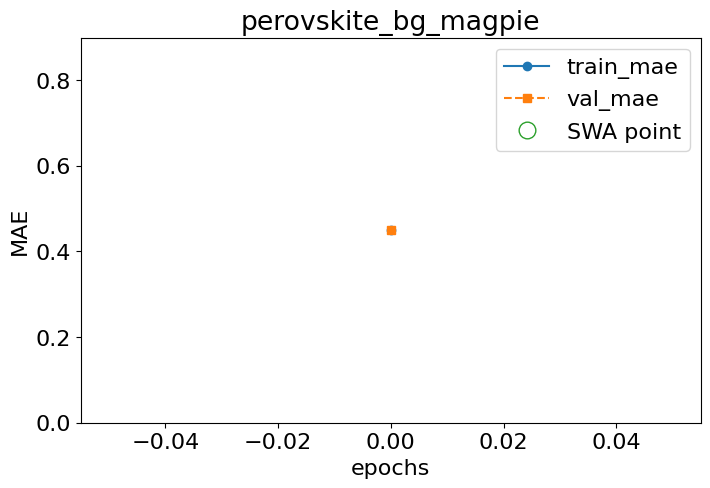

Epoch: 19/300 --- train mae: 0.326 val mae: 0.329


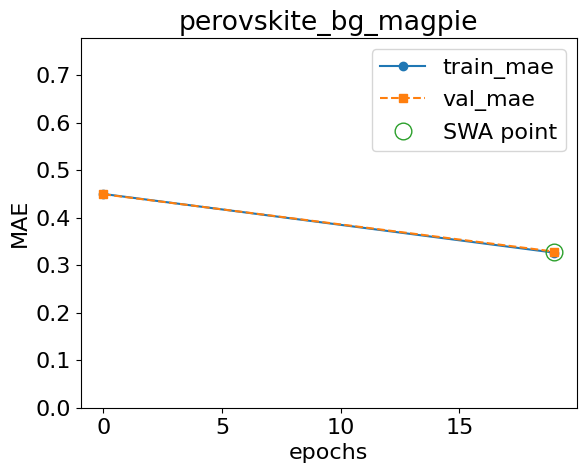

Epoch: 39/300 --- train mae: 0.263 val mae: 0.306


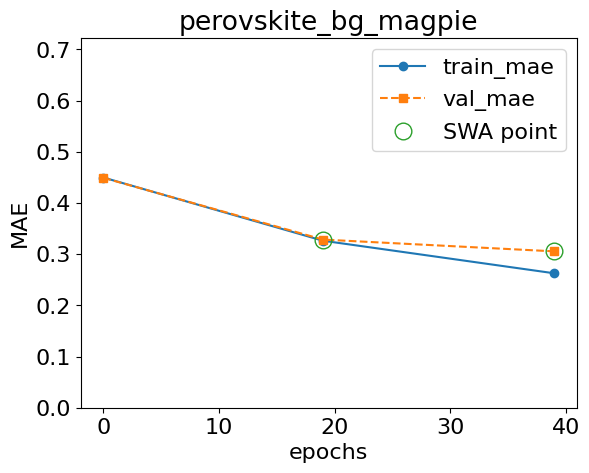

Epoch: 59/300 --- train mae: 0.25 val mae: 0.296


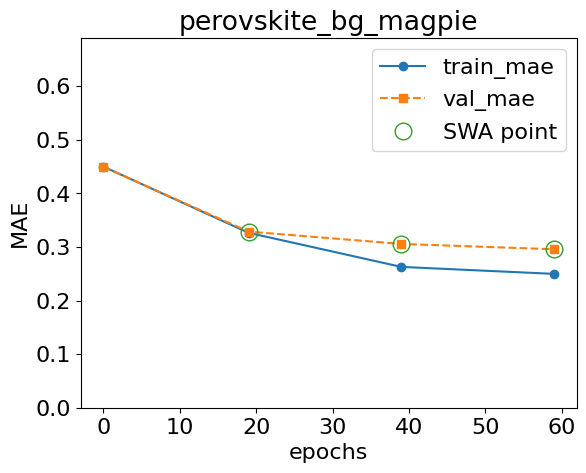

Epoch: 79/300 --- train mae: 0.24 val mae: 0.296


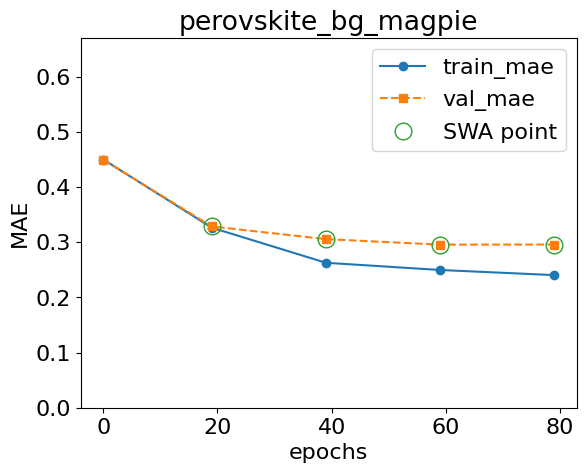

Epoch: 99/300 --- train mae: 0.221 val mae: 0.286


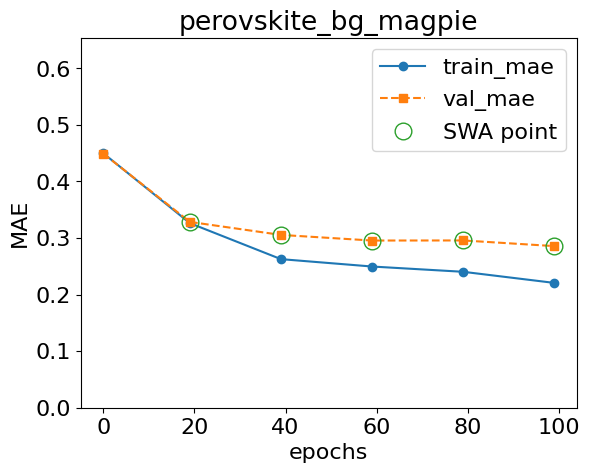

Epoch: 119/300 --- train mae: 0.208 val mae: 0.287


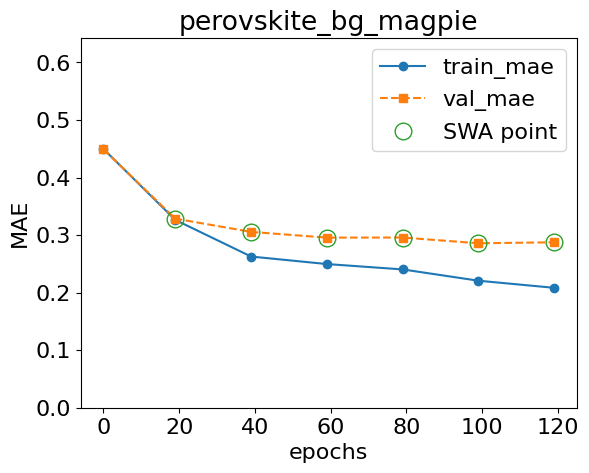

Epoch: 139/300 --- train mae: 0.205 val mae: 0.282


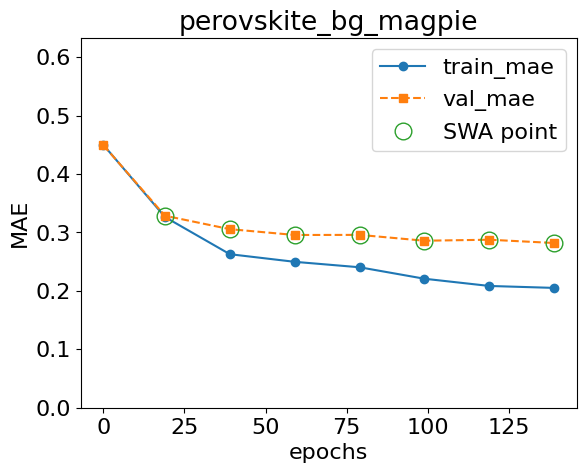

Epoch 159 failed to improve.
Discarded: 1/3 weight updates
Epoch: 159/300 --- train mae: 0.206 val mae: 0.289


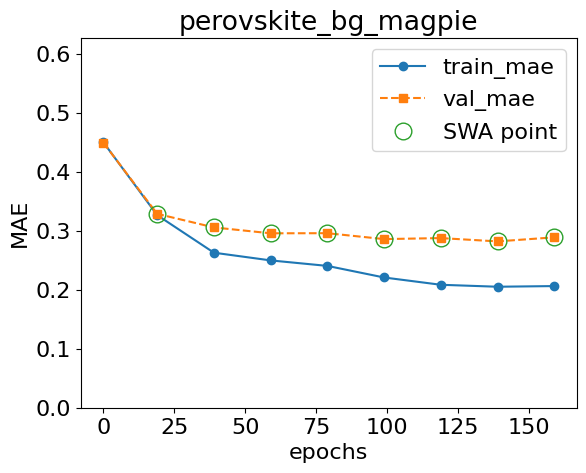

Epoch: 179/300 --- train mae: 0.178 val mae: 0.28


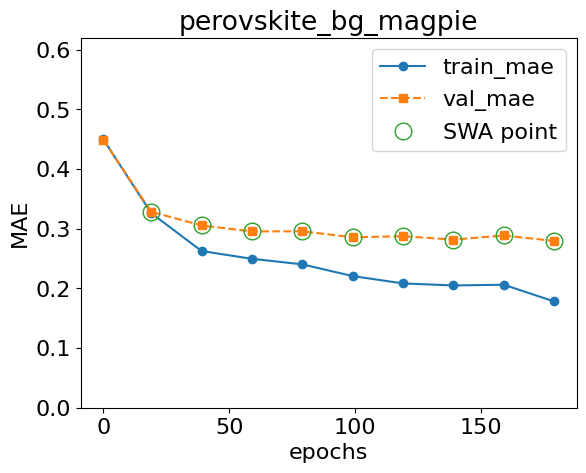

Epoch: 199/300 --- train mae: 0.157 val mae: 0.272


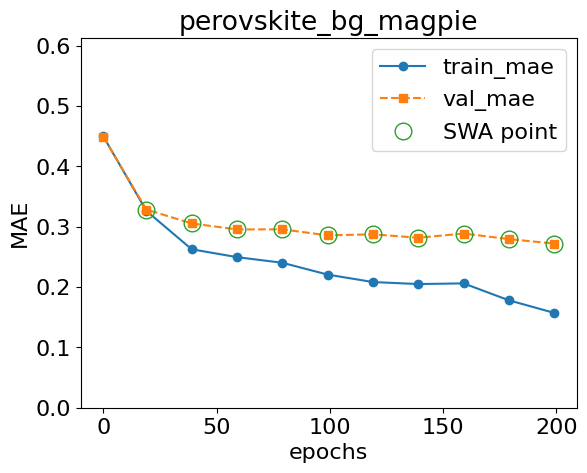

Epoch: 219/300 --- train mae: 0.136 val mae: 0.273


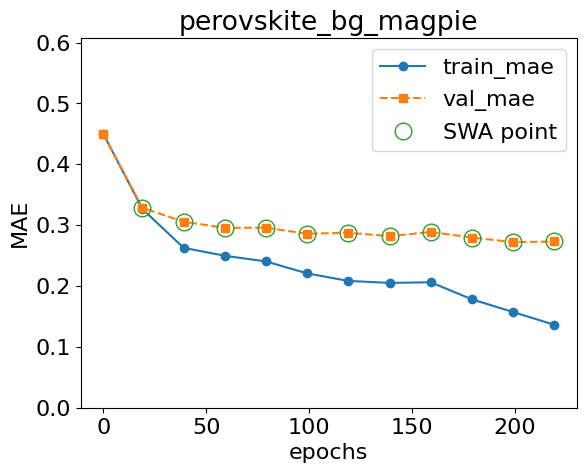

Epoch 239 failed to improve.
Discarded: 2/3 weight updates
Epoch: 239/300 --- train mae: 0.115 val mae: 0.276


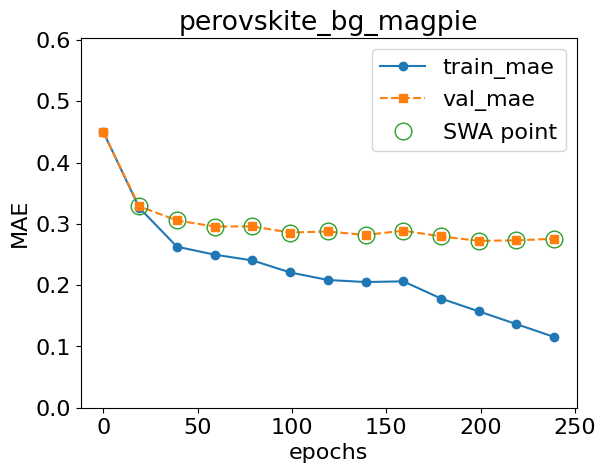

Epoch: 259/300 --- train mae: 0.0958 val mae: 0.266


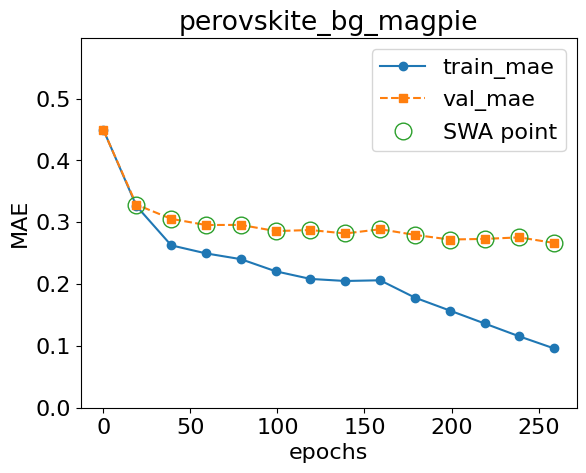

Epoch: 279/300 --- train mae: 0.0801 val mae: 0.266


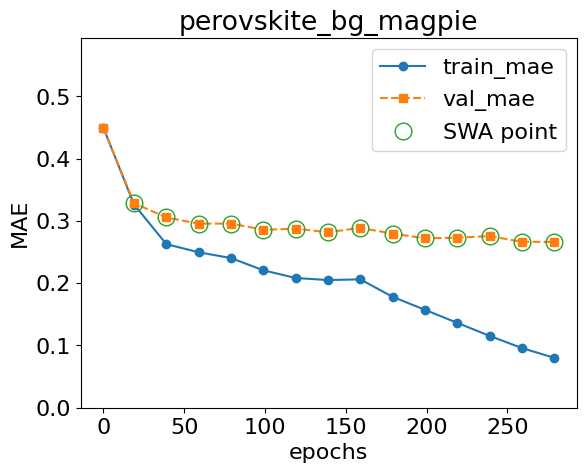

Epoch: 299/300 --- train mae: 0.0702 val mae: 0.264


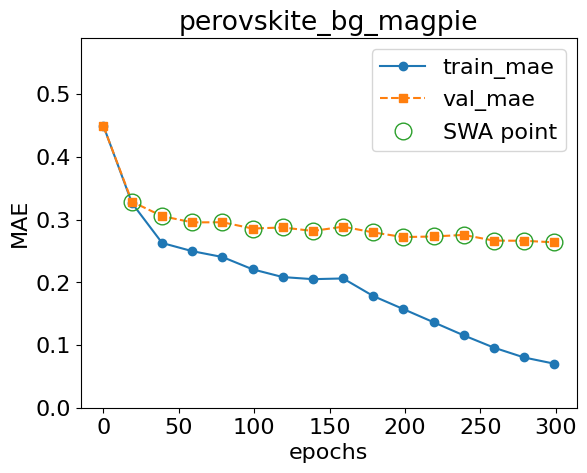

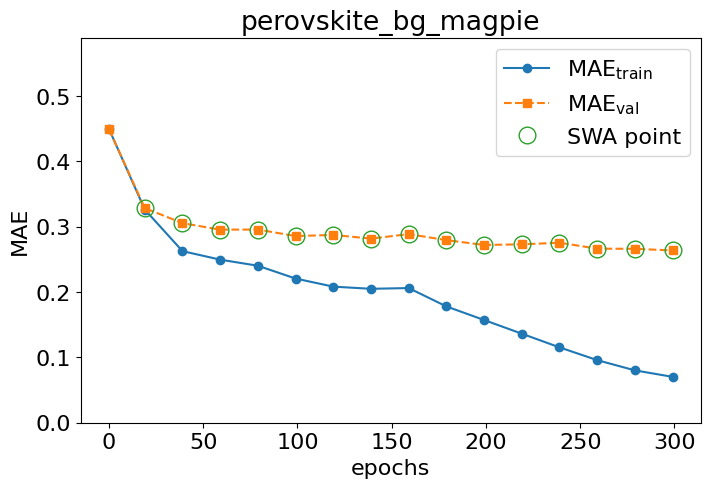

Saving network (perovskite_bg_magpie) to models/trained_models/perovskite_bg_magpie.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 311802.65formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.2796
MSE: 0.3115
MAE: 0.2736 eV

Encoder: mat2vec

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 301067.80formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 245887.01formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.462 val mae: 0.465


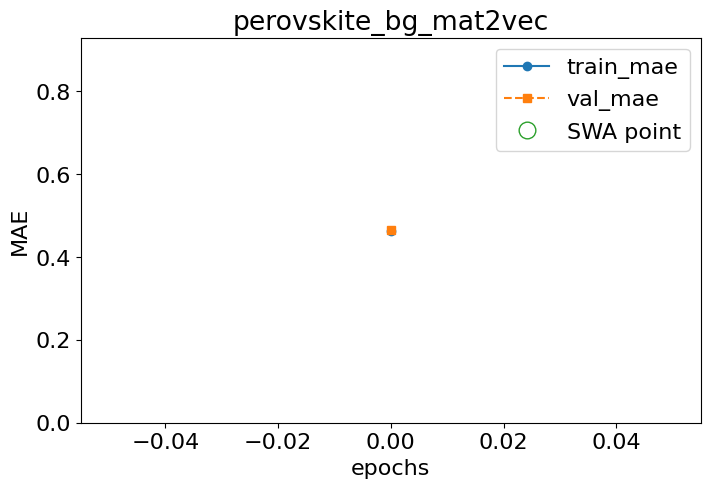

Epoch: 19/300 --- train mae: 0.243 val mae: 0.294


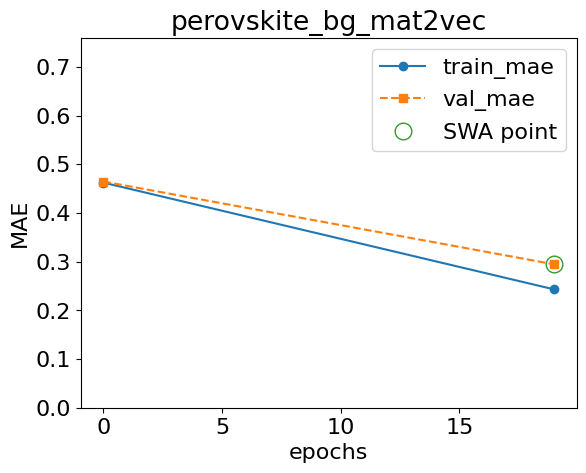

Epoch: 39/300 --- train mae: 0.161 val mae: 0.277


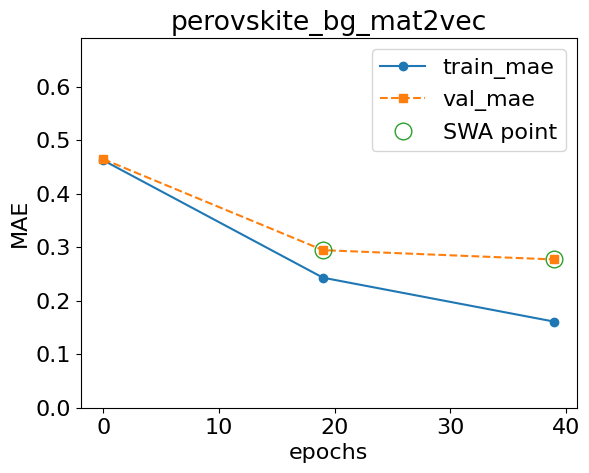

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 0.11 val mae: 0.281


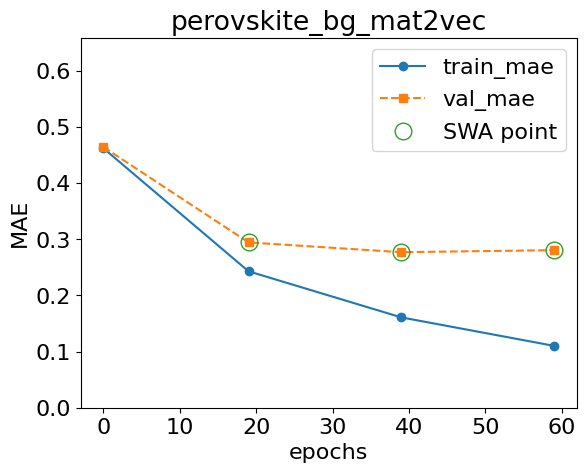

Epoch 79 failed to improve.
Discarded: 2/3 weight updates
Epoch: 79/300 --- train mae: 0.0804 val mae: 0.28


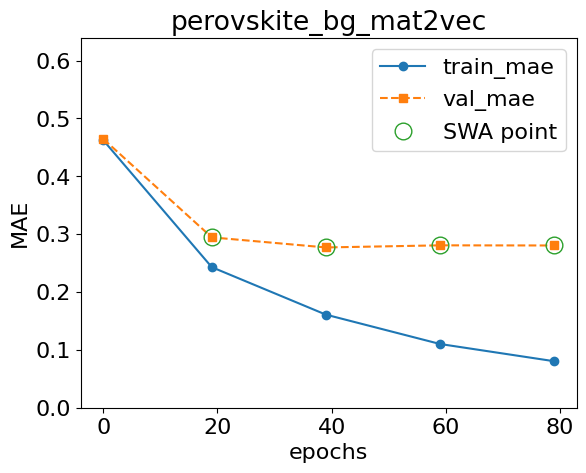

Epoch 99 failed to improve.
Discarded: 3/3 weight updates
Epoch: 99/300 --- train mae: 0.0632 val mae: 0.281


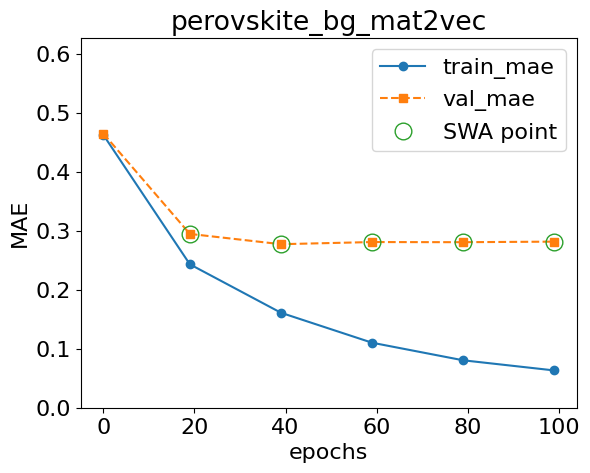

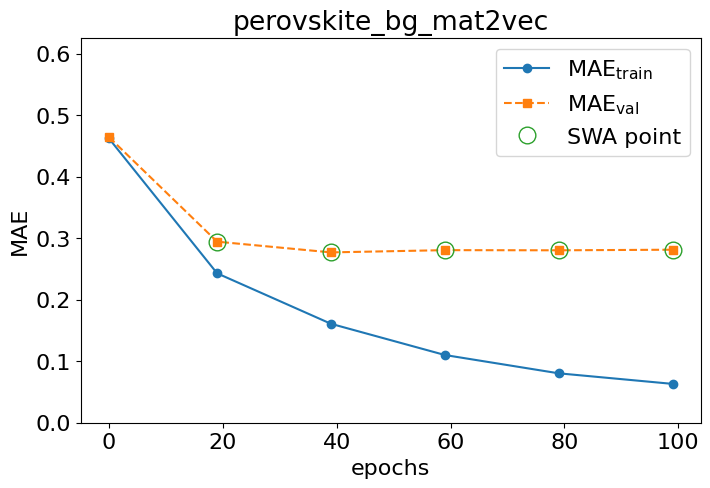

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_mat2vec) to models/trained_models/perovskite_bg_mat2vec.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 318388.20formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3834
MSE: 0.2666
MAE: 0.2703 eV

Encoder: onehot

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11945222 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 307223.05formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 343067.23formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])


loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.456 val mae: 0.456


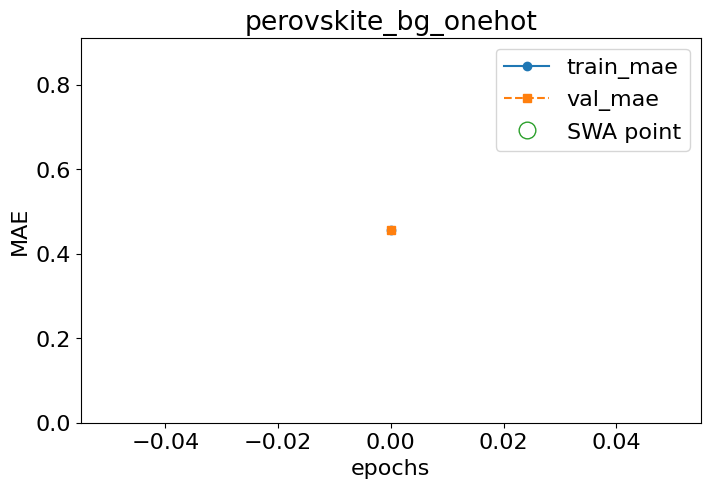

Epoch: 19/300 --- train mae: 0.27 val mae: 0.309


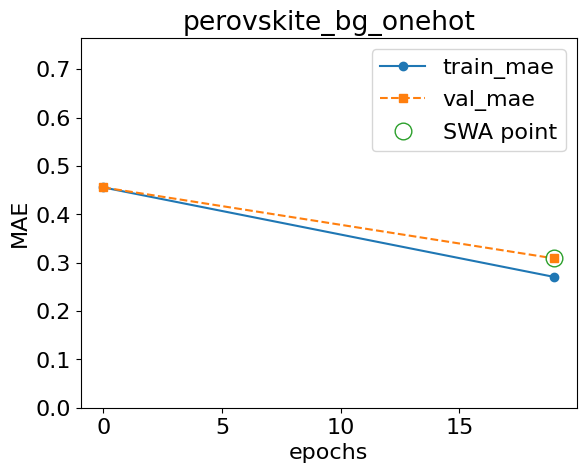

Epoch: 39/300 --- train mae: 0.191 val mae: 0.288


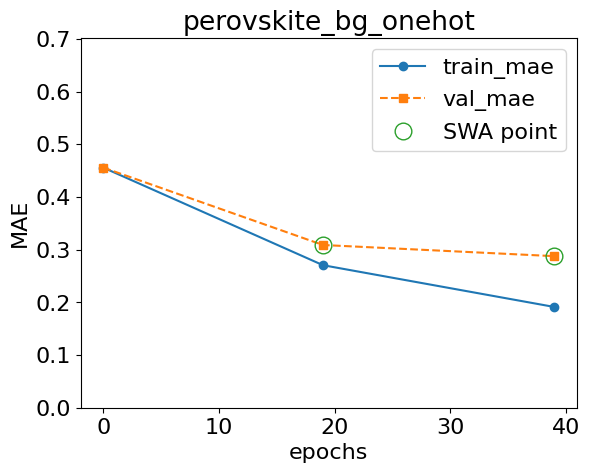

Epoch: 59/300 --- train mae: 0.133 val mae: 0.278


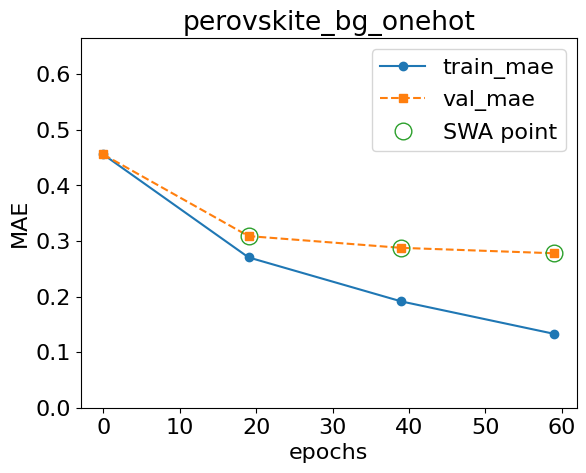

Epoch: 79/300 --- train mae: 0.0925 val mae: 0.27


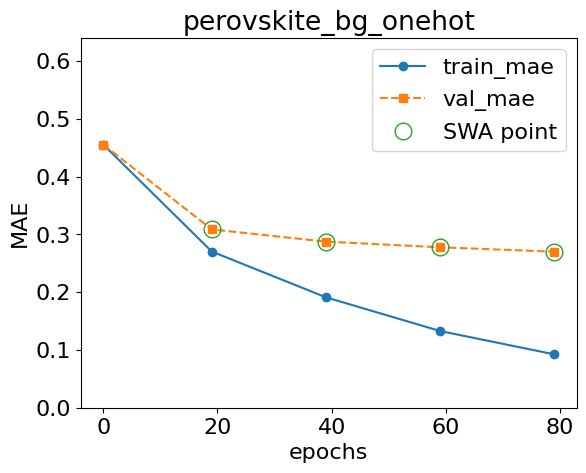

Epoch: 99/300 --- train mae: 0.0695 val mae: 0.266


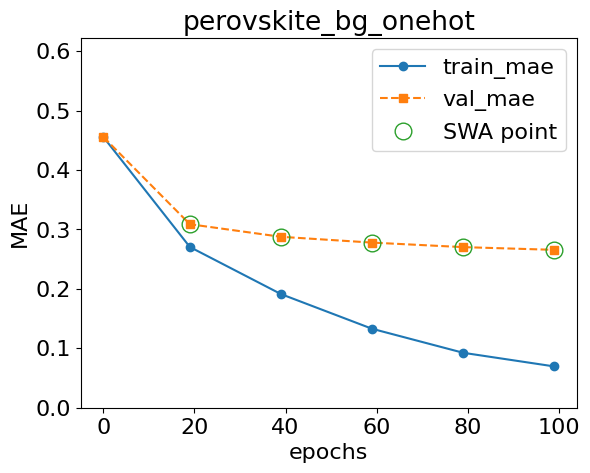

Epoch: 119/300 --- train mae: 0.0566 val mae: 0.262


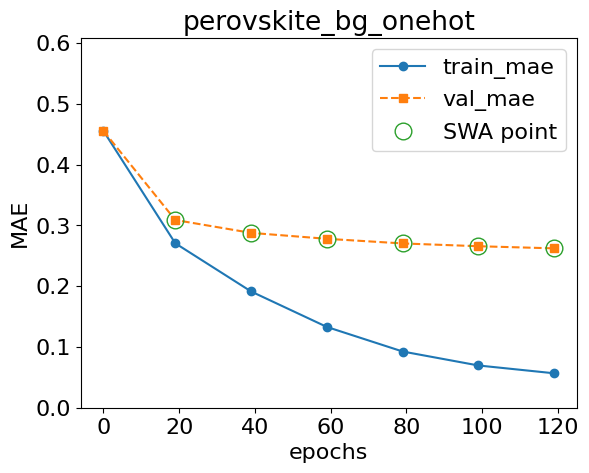

Epoch 139 failed to improve.
Discarded: 1/3 weight updates
Epoch: 139/300 --- train mae: 0.047 val mae: 0.266


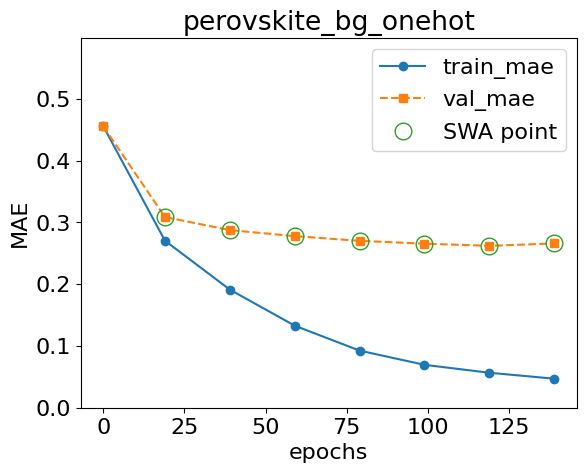

Epoch 159 failed to improve.
Discarded: 2/3 weight updates
Epoch: 159/300 --- train mae: 0.0409 val mae: 0.267


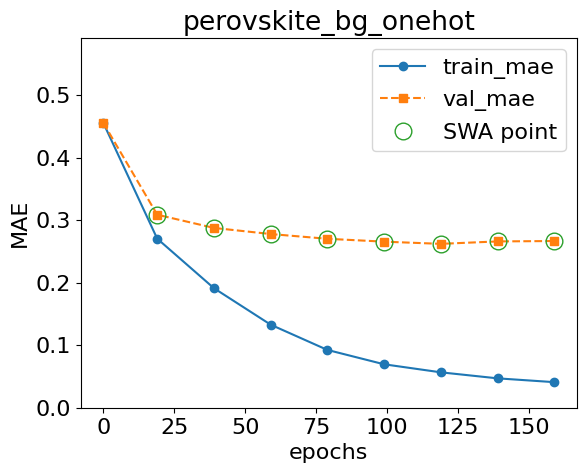

Epoch: 179/300 --- train mae: 0.0361 val mae: 0.265


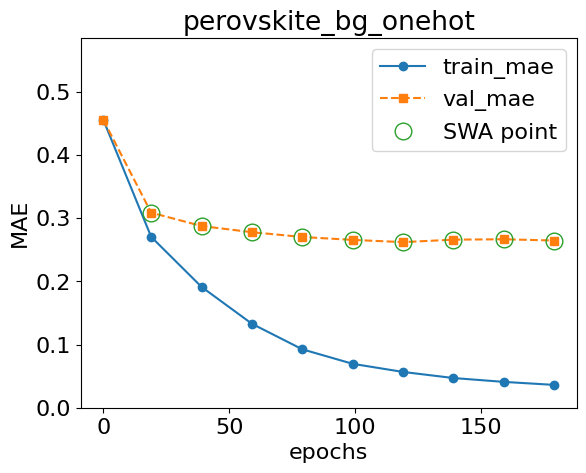

Epoch 199 failed to improve.
Discarded: 3/3 weight updates
Epoch: 199/300 --- train mae: 0.0327 val mae: 0.268


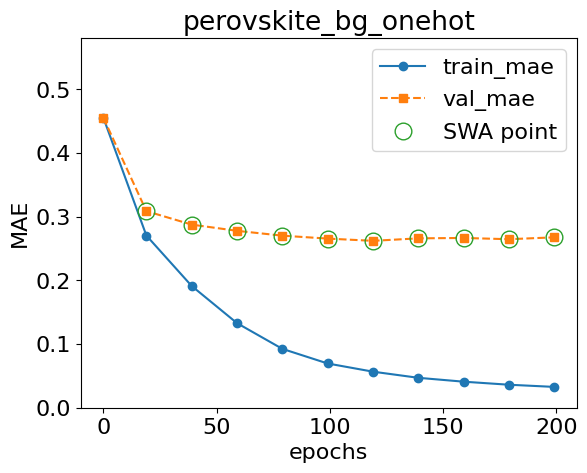

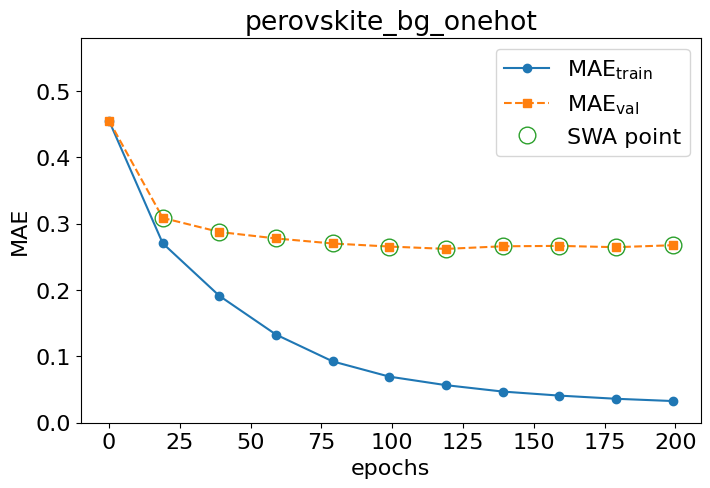

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_onehot) to models/trained_models/perovskite_bg_onehot.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 326233.63formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3870
MSE: 0.2650
MAE: 0.2604 eV

Encoder: random_200

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 301881.70formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 333012.33formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.462 val mae: 0.464


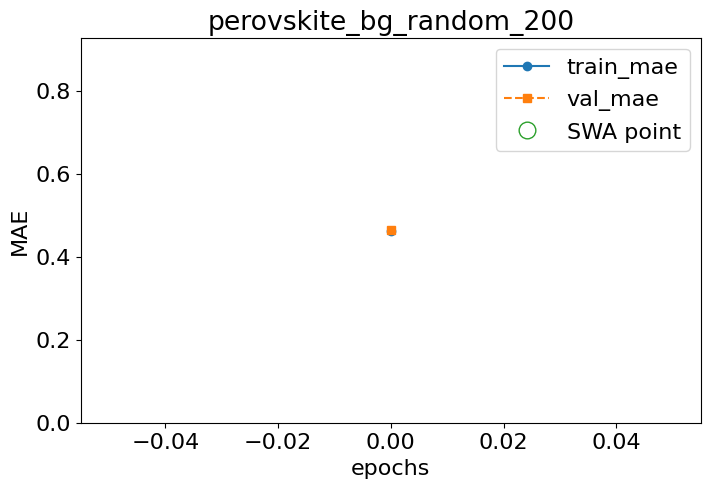

Epoch: 19/300 --- train mae: 0.297 val mae: 0.317


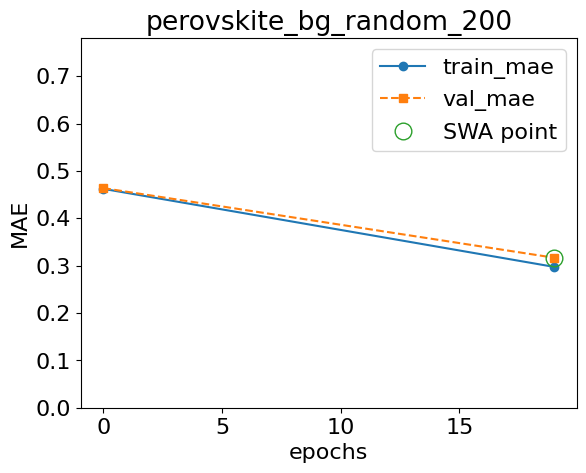

Epoch: 39/300 --- train mae: 0.207 val mae: 0.295


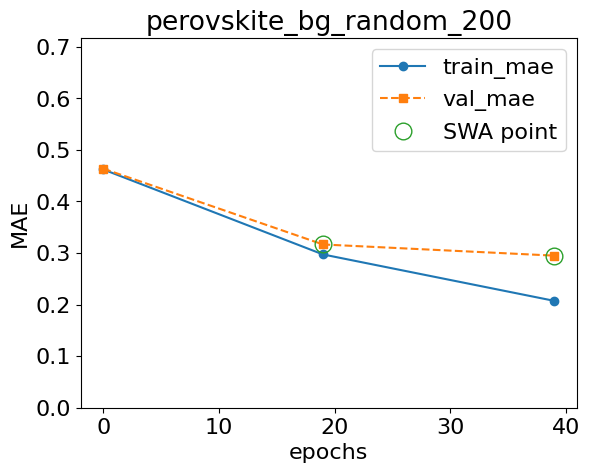

Epoch: 59/300 --- train mae: 0.141 val mae: 0.284


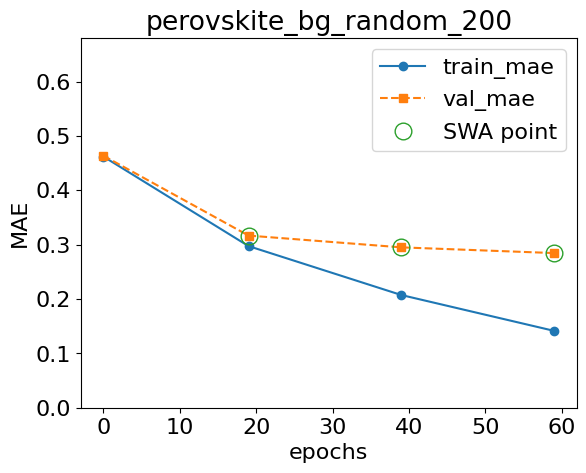

Epoch: 79/300 --- train mae: 0.0983 val mae: 0.275


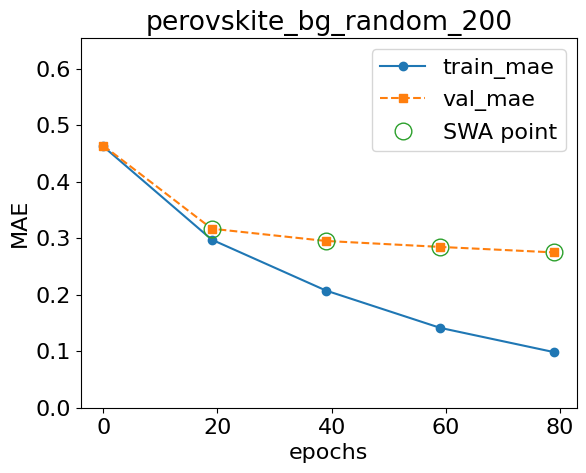

Epoch: 99/300 --- train mae: 0.0735 val mae: 0.265


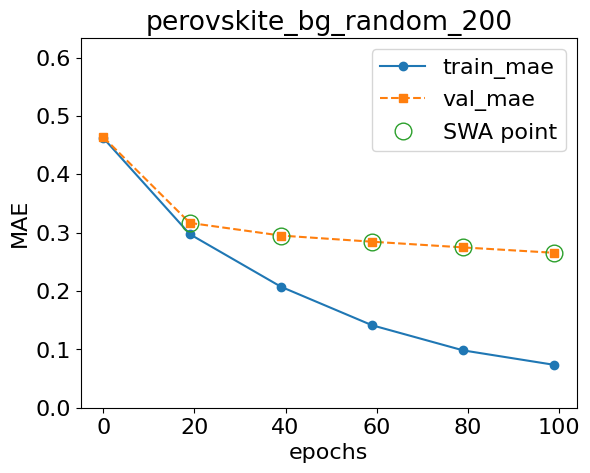

Epoch 119 failed to improve.
Discarded: 1/3 weight updates
Epoch: 119/300 --- train mae: 0.0595 val mae: 0.271


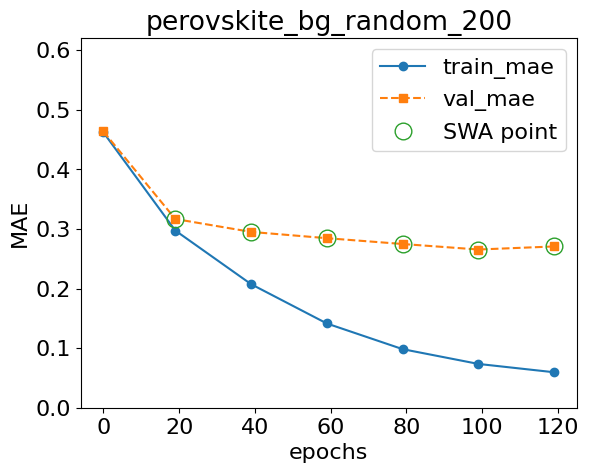

Epoch: 139/300 --- train mae: 0.05 val mae: 0.266


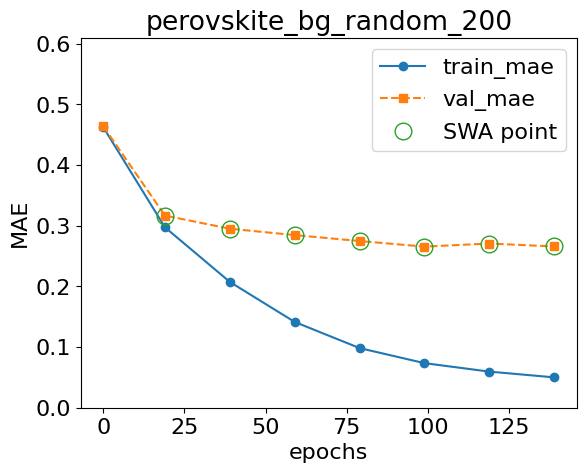

Epoch: 159/300 --- train mae: 0.0424 val mae: 0.267


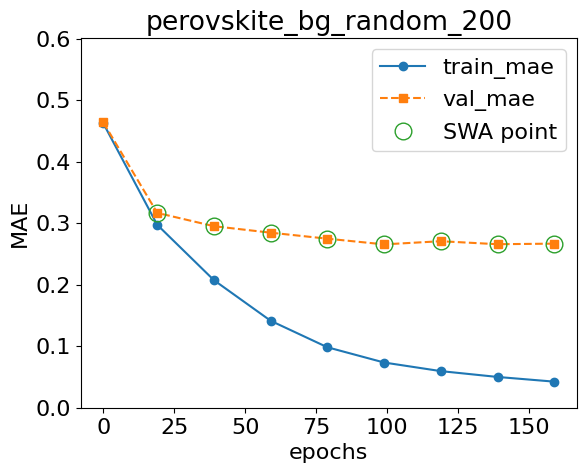

Epoch 179 failed to improve.
Discarded: 2/3 weight updates
Epoch: 179/300 --- train mae: 0.0371 val mae: 0.269


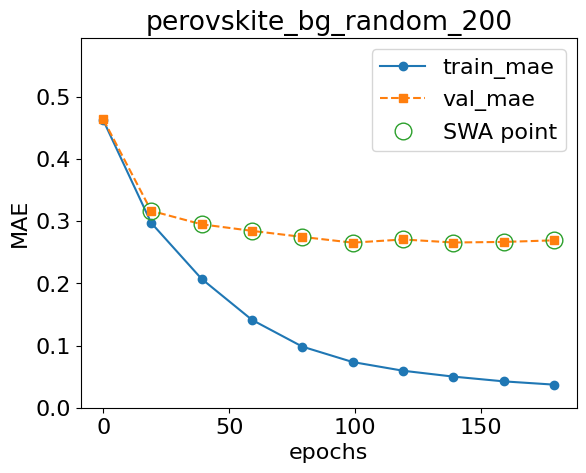

Epoch 199 failed to improve.
Discarded: 3/3 weight updates
Epoch: 199/300 --- train mae: 0.0346 val mae: 0.269


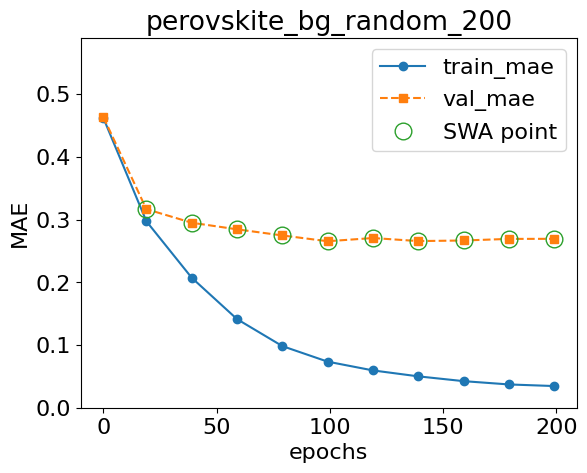

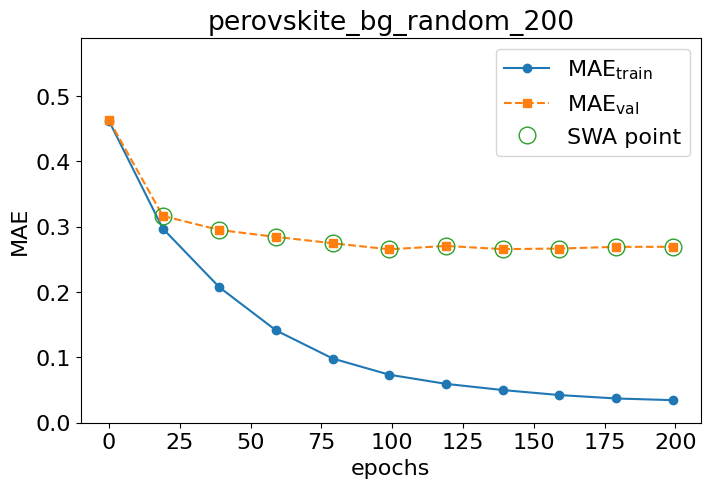

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_random_200) to models/trained_models/perovskite_bg_random_200.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 318388.20formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.4204
MSE: 0.2506
MAE: 0.2447 eV

Encoder: pettifor

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11934982 parameters



Generating EDM:   0%|          | 0/2902 [00:00<?, ?formulae/s]

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 293751.09formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 327919.96formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.457 val mae: 0.459


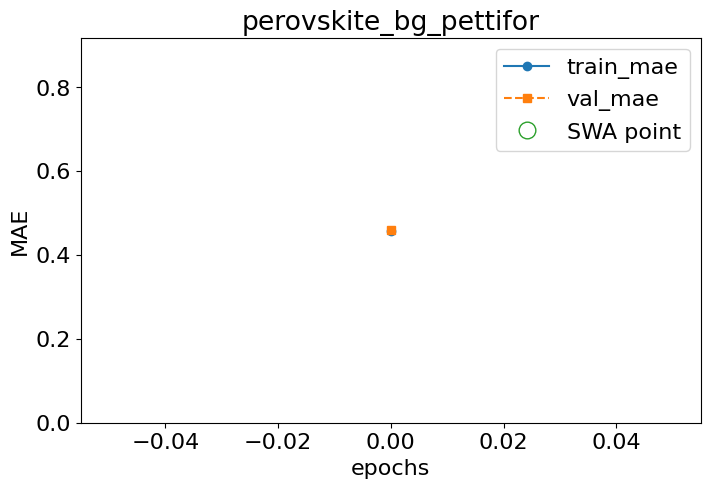

Epoch: 19/300 --- train mae: 0.28 val mae: 0.319


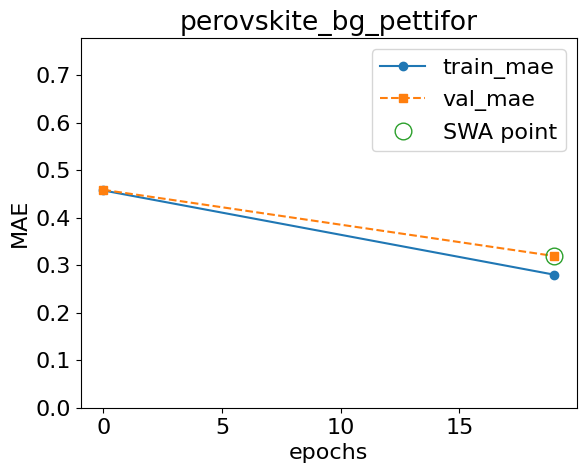

Epoch: 39/300 --- train mae: 0.196 val mae: 0.277


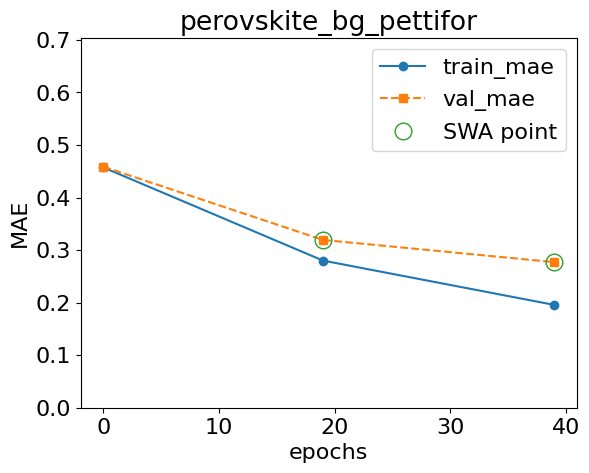

Epoch: 59/300 --- train mae: 0.143 val mae: 0.271


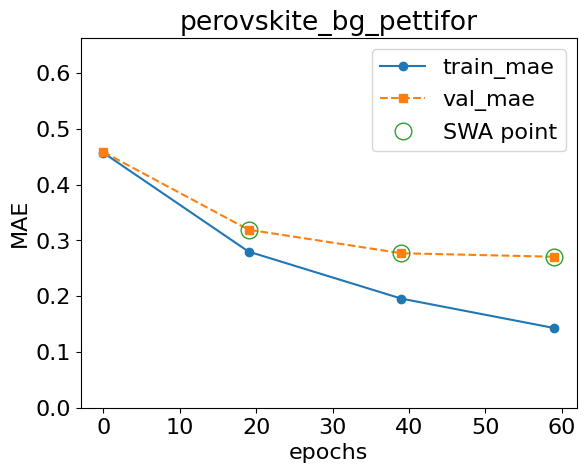

Epoch: 79/300 --- train mae: 0.0999 val mae: 0.27


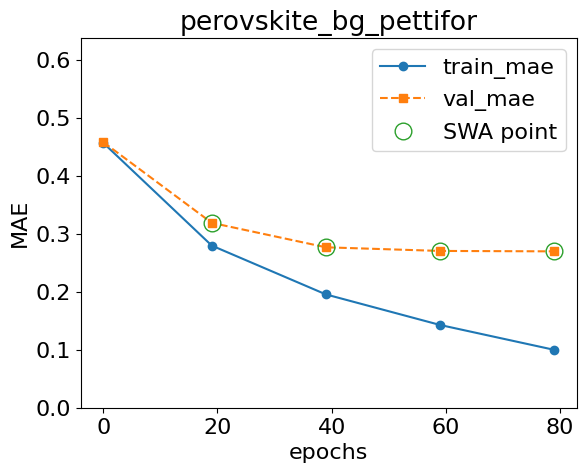

Epoch: 99/300 --- train mae: 0.0729 val mae: 0.266


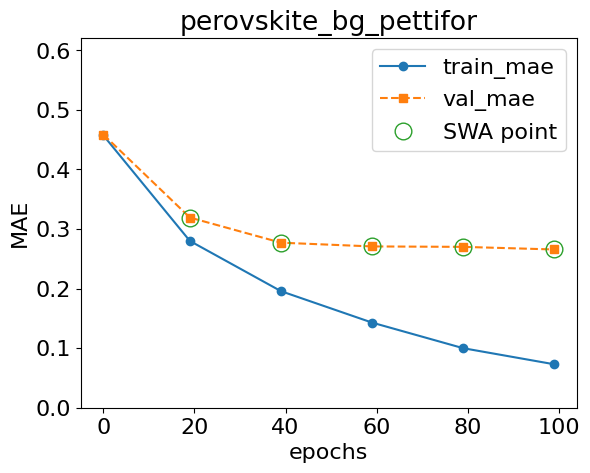

Epoch: 119/300 --- train mae: 0.058 val mae: 0.263


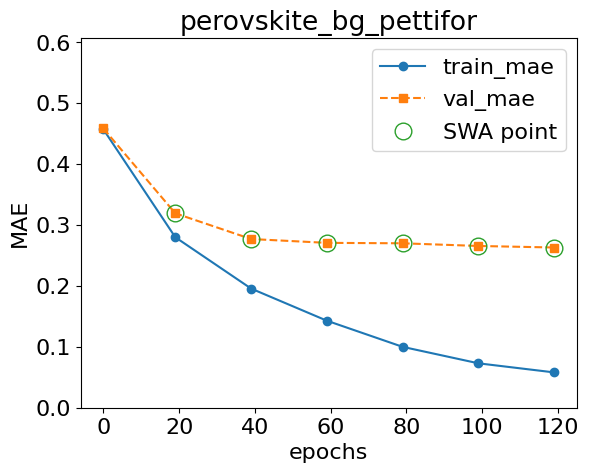

Epoch: 139/300 --- train mae: 0.0455 val mae: 0.261


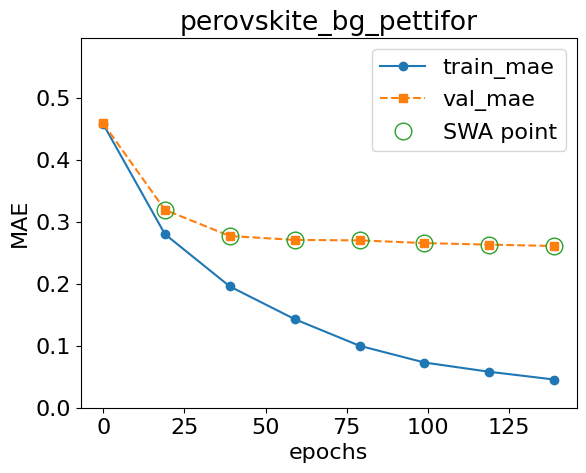

Epoch: 159/300 --- train mae: 0.0393 val mae: 0.257


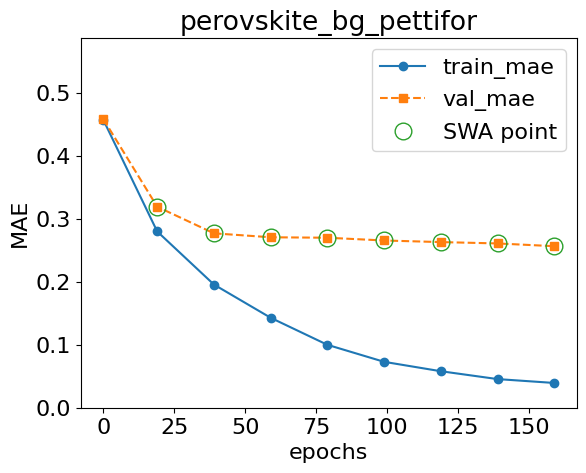

Epoch: 179/300 --- train mae: 0.0354 val mae: 0.254


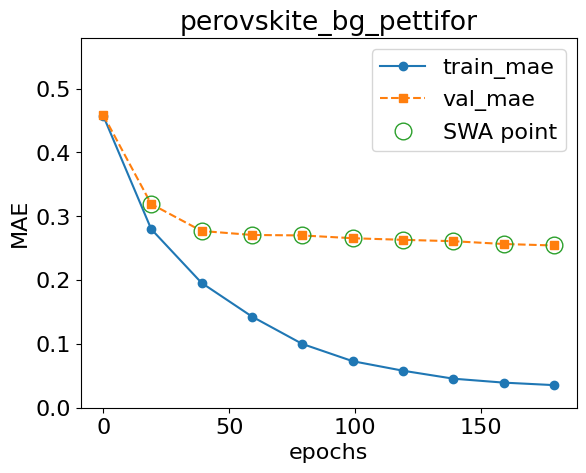

Epoch 199 failed to improve.
Discarded: 1/3 weight updates
Epoch: 199/300 --- train mae: 0.0316 val mae: 0.256


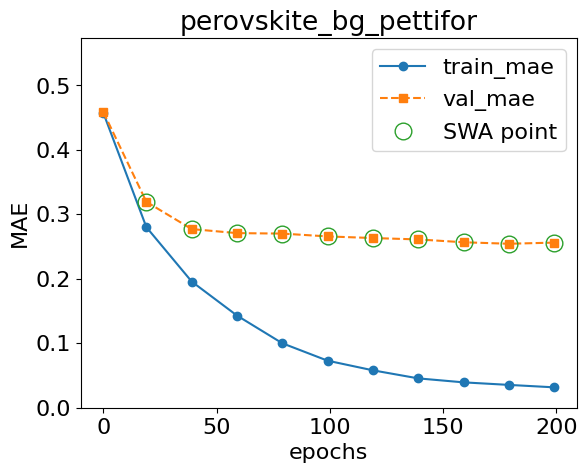

Epoch: 219/300 --- train mae: 0.0304 val mae: 0.255


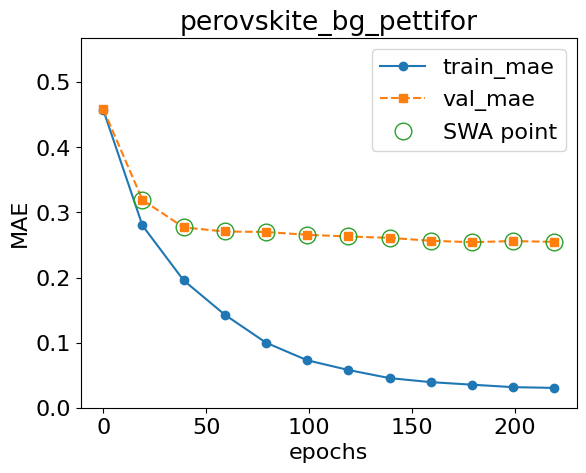

Epoch: 239/300 --- train mae: 0.0286 val mae: 0.256


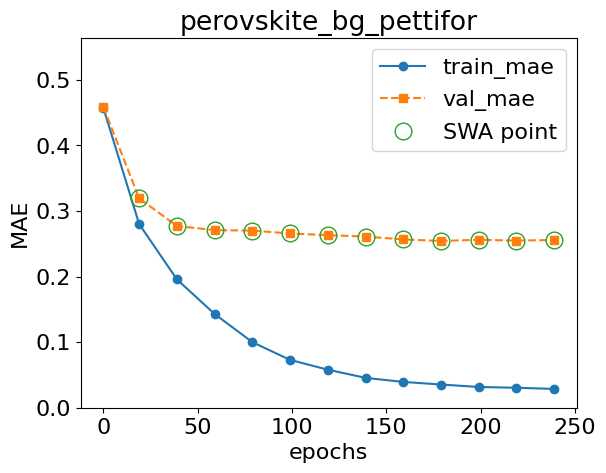

Epoch 259 failed to improve.
Discarded: 2/3 weight updates
Epoch: 259/300 --- train mae: 0.0272 val mae: 0.256


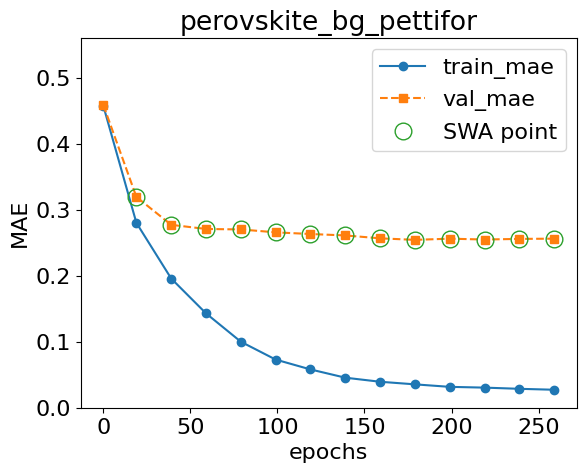

Epoch: 279/300 --- train mae: 0.0264 val mae: 0.255


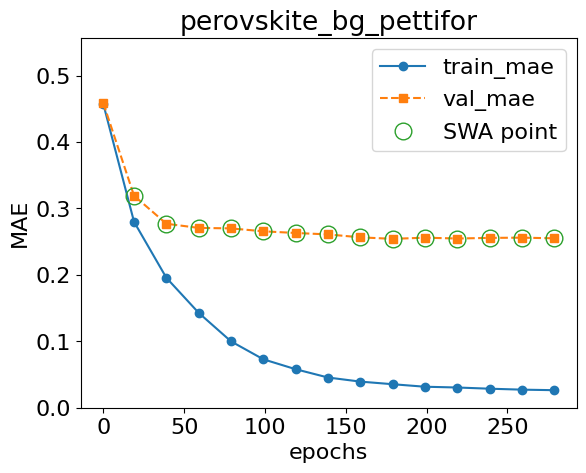

Epoch 299 failed to improve.
Discarded: 3/3 weight updates
Epoch: 299/300 --- train mae: 0.0251 val mae: 0.256


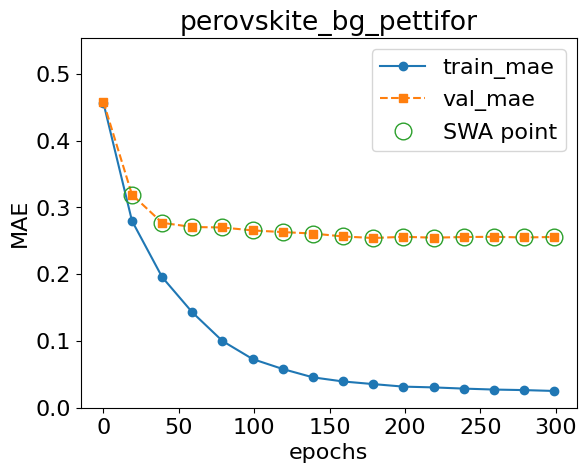

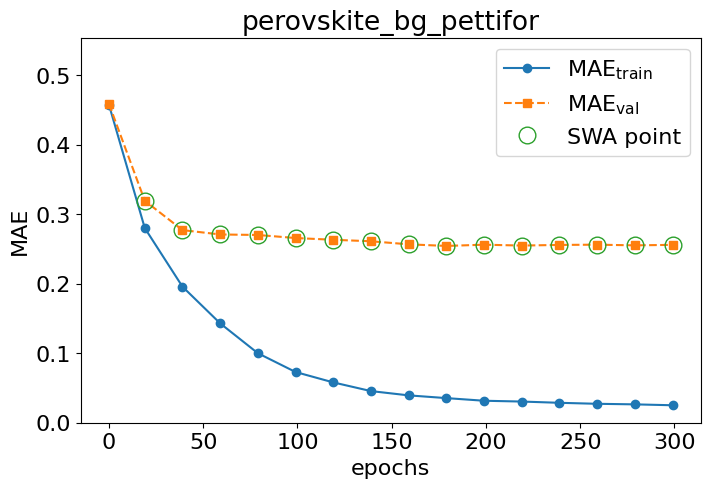

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_pettifor) to models/trained_models/perovskite_bg_pettifor.pth


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 337365.91formulae/s]

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
R2 score: 0.3601
MSE: 0.2767
MAE: 0.2625 eV


,encoder,R²,MAE (eV),RMSE (eV)
3,random_200,0.420,0.245,0.501
2,onehot,0.387,0.260,0.515
4,pettifor,0.360,0.262,0.526
1,mat2vec,0.383,0.270,0.516
0,magpie,0.280,0.274,0.558


In [7]:
ENCODERS = ['magpie', 'mat2vec', 'onehot', 'random_200', 'pettifor']

# ENCODERS = [ 'onehot', 'pettifor']

encoder_results = []

for encoder in ENCODERS:
    print(f'\n{"="*50}')
    print(f'Encoder: {encoder}')
    print(f'{"="*50}')

    model_name = f'perovskite_bg_{encoder}'

    model = CrabNet(
        mat_prop='bandgap',
        model_name=model_name,
        elem_prop=encoder,
        learningcurve=True,
    )
    model.fit(train_base.copy(), val_base.copy())

    m = test_r2_score(
        test_base, feature_names=None,
        crabnet_bandgap=model, plot=False,
    )

    encoder_results.append({
        'encoder': encoder,
        'R²': m['r2'],
        'MAE (eV)': m['mae'],
        'RMSE (eV)': np.sqrt(m['mse']),
    })

enc_table = pd.DataFrame(encoder_results).sort_values('MAE (eV)')
enc_table.style.format({'R²': '{:.3f}', 'MAE (eV)': '{:.3f}', 'RMSE (eV)': '{:.3f}'})

## Comparison Bar Chart

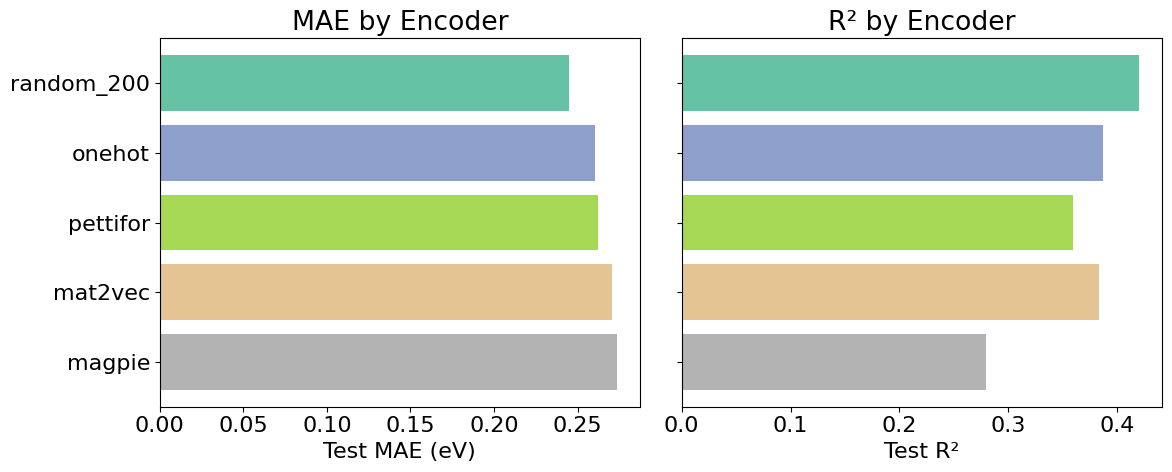

Saved to /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV/reports/figures/encoder_comparison.pdf


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

colors = plt.cm.Set2(np.linspace(0, 1, len(enc_table)))

# MAE
axes[0].barh(enc_table['encoder'], enc_table['MAE (eV)'], color=colors)
axes[0].set_xlabel('Test MAE (eV)')
axes[0].set_title('MAE by Encoder')
axes[0].invert_yaxis()

# R²
axes[1].barh(enc_table['encoder'], enc_table['R²'], color=colors)
axes[1].set_xlabel('Test R²')
axes[1].set_title('R² by Encoder')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'encoder_comparison.pdf')
fig.savefig(FIGURES_DIR / 'encoder_comparison.png')
plt.show()
print(f'Saved to {FIGURES_DIR / "encoder_comparison.pdf"}')